In [ ]:
# For website deployed environment
%pip install -q ipywidgets

In [1]:
# Load required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage.filters import threshold_otsu
from skimage.color import rgb2lab
from scipy.ndimage import gaussian_filter, label
import rasterio
from rasterio.plot import show
from PIL import Image
from ipywidgets import interact, FloatSlider
import os
import sys
from pathlib import Path

# Add the parent directory to the Python path
sys.path.append(str(Path.cwd().parent))

%matplotlib inline

# Plant Search Demo
A quick demonstration of using simple, unsupervised techniques to locate plants from and image.

## Load and Display Image


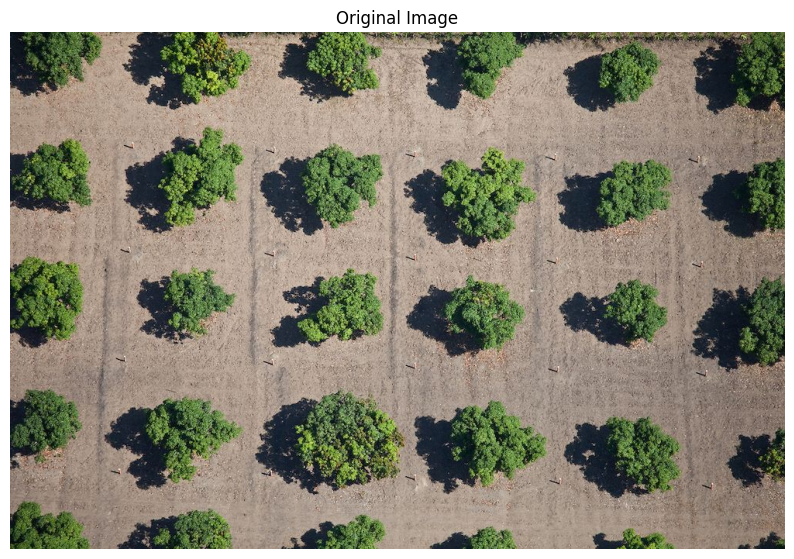

In [2]:
from plant_search.load_image import load_image, plot_image


# file_path = 'input/ESPG-4326-orthophoto.tif'
# file_path = 'input/MADRID_RGB.tif'
file_path = '../input/aerial-trees.jpg'

image = load_image(file_path)
if image is not None:
    plot_image(image, "Original Image")


## Image Preprocessing

### LAB Image Color Space

Expected Results:

- **L**: A grayscale image showing brightness across the image.
- **A**: Red-dominated areas should appear positive (bright), while green-dominated areas should appear negative (dark).
- **B**: Highlights blue-to-yellow dominance.

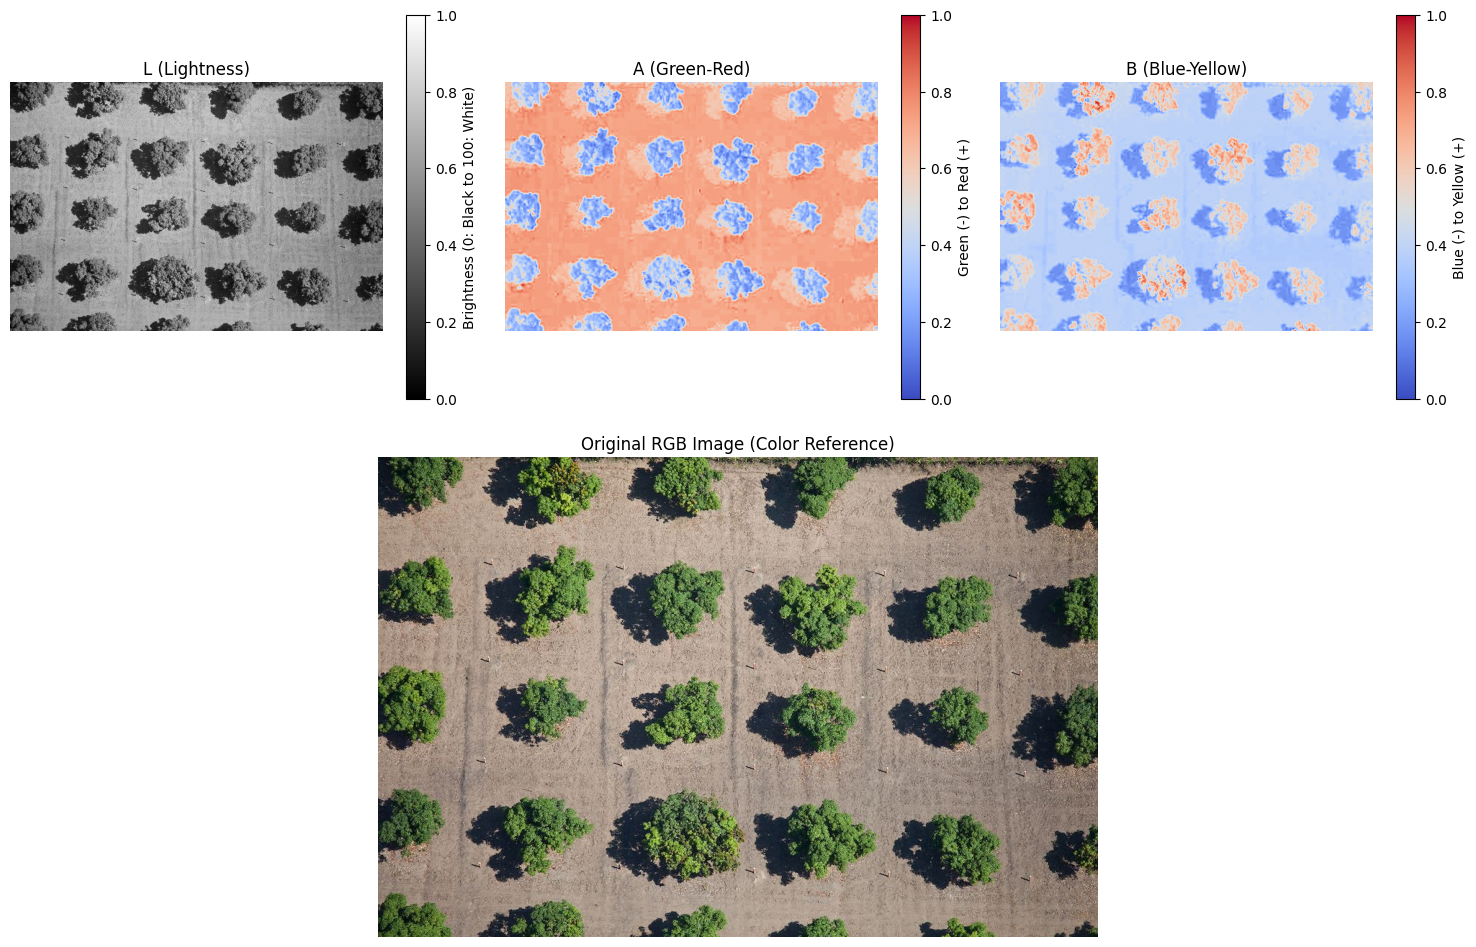

In [3]:
lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
L, A, B = cv2.split(lab_image)

# Set up the grid layout using gridspec
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, height_ratios=[1, 1])  # Equal height for both rows

# First Row: LAB Channels
# L (Lightness)
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(L, cmap='gray')
ax1.set_title("L (Lightness)")
ax1.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=ax1, shrink=0.8)
cbar.set_label("Brightness (0: Black to 100: White)")

# A (Green-Red)
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(A, cmap='coolwarm')
ax2.set_title("A (Green-Red)")
ax2.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=ax2, shrink=0.8)
cbar.set_label("Green (-) to Red (+)")

# B (Blue-Yellow)
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(B, cmap='coolwarm')
ax3.set_title("B (Blue-Yellow)")
ax3.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=ax3, shrink=0.8)
cbar.set_label("Blue (-) to Yellow (+)")

# Second Row: Original Image in Color
ax4 = fig.add_subplot(gs[1, :])  # Span all columns in the second row
ax4.imshow(image)
ax4.set_title("Original RGB Image (Color Reference)")
ax4.axis("off")

plt.tight_layout()
plt.show()

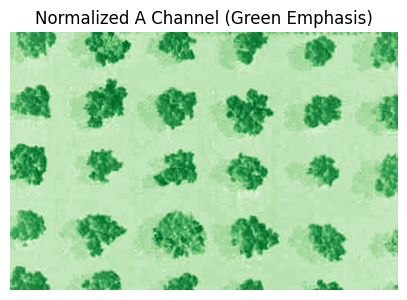

In [4]:
# Normalize the green-dominant range in the A channel
A_normalized = -A  # Flip to make green positive
A_normalized = (A_normalized - A_normalized.min()) / (A_normalized.max() - A_normalized.min())
# A_normalized = -A  # Flip to make green positive

# Visualize normalized green emphasis
plt.figure(figsize=(5, 4))
plt.imshow(A_normalized, cmap='Greens')
plt.title("Normalized A Channel (Green Emphasis)")
plt.axis("off")
plt.show()


## Threshold and Mask

In [ ]:
# Function to overlay the mask on the original image
def overlay_mask(image, mask, color=(0, 255, 0), alpha=0.5):
    """
    Overlay the binary mask on the original image.
    
    Parameters:
    - image: Original RGB image (H, W, 3).
    - mask: Binary mask (H, W), values are True for mask.
    - color: Tuple (R, G, B) for the overlay color.
    - alpha: Transparency of the overlay (0 = transparent, 1 = opaque).
    
    Returns:
    - Image with overlay applied.
    """
    overlay = np.zeros_like(image, dtype=np.uint8)
    overlay[mask] = color  # Apply color to mask regions
    
    blended = image.copy()
    blended[mask] = (blended[mask] * (1 - alpha) + overlay[mask] * alpha).astype(np.uint8)
    # blended = (blended * (1 - alpha) + overlay * alpha).astype(np.uint8)
    return blended

# Interactive function for threshold and opacity adjustment
def update_threshold_and_opacity(threshold, opacity):
    green_mask = A_normalized > threshold  # Apply threshold
    
    # Create the overlayed image
    overlayed_image = overlay_mask(image, green_mask, color=(0, 255, 0), alpha=opacity)
    
    # Visualize the overlay
    plt.figure(figsize=(10, 8))
    plt.imshow(overlayed_image)
    plt.title(f"Overlayed Image (Threshold = {threshold:.2f}, Opacity = {opacity:.2f})")
    plt.axis("off")
    plt.show()

# Create interactive sliders for threshold and opacity adjustment
interact(
    update_threshold_and_opacity,
    threshold=FloatSlider(value=0.75, min=0.0, max=1.0, step=0.01, description="Threshold"),
    opacity=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description="Opacity")
);

interactive(children=(FloatSlider(value=0.75, description='Threshold', max=1.0, step=0.01), FloatSlider(value=…

In [6]:

# Function to apply thresholding and visualize the green mask
def update_threshold(threshold):
    green_mask = A_normalized > threshold  # Apply threshold
    
    # Create a side-by-side comparison plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    
    # Original RGB image
    axes[0].imshow(image)
    axes[0].set_title("Original RGB Image")
    axes[0].axis("off")
    
    # Green mask
    axes[1].imshow(green_mask, cmap='Greens')
    axes[1].set_title(f"Green Mask (Threshold = {threshold:.2f})")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Create an interactive slider for threshold adjustment
start_value = 0.75
interact(update_threshold, threshold=FloatSlider(value=start_value, min=0.0, max=1.0, step=0.01));


interactive(children=(FloatSlider(value=0.75, description='threshold', max=1.0, step=0.01), Output()), _dom_cl…

#### Refine Image Mask


In [7]:
def refine_mask(mask, kernel_size=5, min_size=50):
    """
    Refine the binary mask using morphological operations and size filtering.
    
    Parameters:
    - mask: Binary mask (H, W), values are True for plants and False for background.
    - kernel_size: Size of the structuring element for morphological operations.
    - min_size: Minimum size of connected components to retain.
    
    Returns:
    - Refined mask.
    """
    # Convert mask to uint8 for OpenCV operations
    mask = mask.astype(np.uint8)
    
    # Create a structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    
    # Apply closing (dilation followed by erosion)
    refined_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Remove small components based on size
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(refined_mask, connectivity=8)
    for i in range(1, num_labels):  # Skip the background (label 0)
        area = stats[i, cv2.CC_STAT_AREA]
        if area < min_size:
            refined_mask[labels == i] = 0
    
    return refined_mask > 0  # Return as binary mask (True/False)

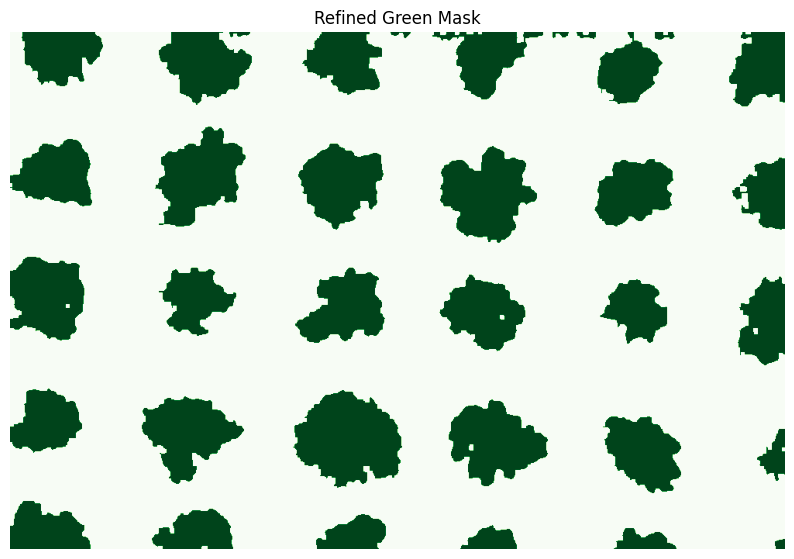

In [8]:
# Apply the threshold to get the initial mask
threshold = 0.45  # Adjust as needed
green_mask = A_normalized > threshold

# Refine the mask
refined_green_mask = refine_mask(green_mask, kernel_size=5, min_size=100)

# Visualize the refined mask
plt.figure(figsize=(10, 8))
plt.imshow(refined_green_mask, cmap='Greens')
plt.title("Refined Green Mask")
plt.axis("off")
plt.show()


## Draw Bounding Boxes

In [9]:

# Generate bounding boxes from the binary mask
def find_bounding_boxes(mask):
    """
    Finds bounding boxes for connected components in the binary mask.
    
    Parameters:
    - mask: Binary mask (H, W) with True for plants and False for background.
    
    Returns:
    - List of bounding boxes, where each box is (x_min, y_min, x_max, y_max).
    """
    # Label connected components
    labeled_mask, num_features = label(mask)
    bounding_boxes = []
    
    for i in range(1, num_features + 1):  # Start at 1 because 0 is the background
        coords = np.argwhere(labeled_mask == i)
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        bounding_boxes.append((x_min, y_min, x_max, y_max))
    
    return bounding_boxes

# Draw bounding boxes on the original image
def draw_bounding_boxes(image, bounding_boxes, color=(255, 0, 0), thickness=2):
    """
    Draws bounding boxes on the image.
    
    Parameters:
    - image: Original RGB image (H, W, 3).
    - bounding_boxes: List of bounding boxes (x_min, y_min, x_max, y_max).
    - color: RGB tuple for the bounding box color.
    - thickness: Line thickness of the bounding boxes.
    
    Returns:
    - Image with bounding boxes drawn.
    """
    image_with_boxes = image.copy()
    for box in bounding_boxes:
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), color, thickness)
    return image_with_boxes


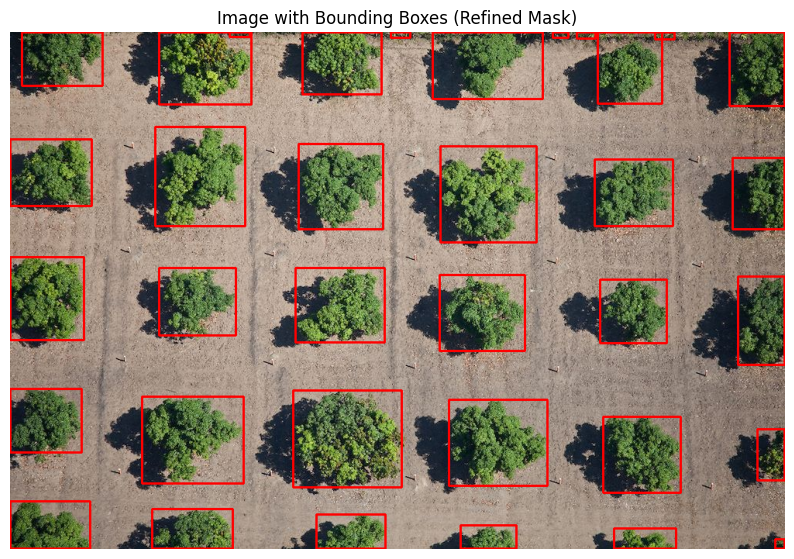

In [10]:
# Find bounding boxes for the refined mask
bounding_boxes = find_bounding_boxes(refined_green_mask)

# Draw bounding boxes on the original image
image_with_boxes = draw_bounding_boxes(image, bounding_boxes)

# Visualize the result
plt.figure(figsize=(10, 8))
plt.imshow(image_with_boxes)
plt.title("Image with Bounding Boxes (Refined Mask)")
plt.axis("off")
plt.show()
